# Programming

## Credit Card Fraud Detection

### Installing Dataset

In [4]:
!gdown 1NwikiUU_Yzom-l4Kwy24Cn-bG46gMmG4

Downloading...
From (original): https://drive.google.com/uc?id=1NwikiUU_Yzom-l4Kwy24Cn-bG46gMmG4
From (redirected): https://drive.google.com/uc?id=1NwikiUU_Yzom-l4Kwy24Cn-bG46gMmG4&confirm=t&uuid=322a0700-cd73-4875-8ed0-b24ab8723ab5
To: /content/creditcard.csv
100% 151M/151M [00:03<00:00, 47.1MB/s]


### Import Libraries

In [5]:
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Read Dataset

In [6]:
dataset_path = "creditcard.csv"
df = pd.read_csv(dataset_path)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Split Data and Label

In [8]:
dataset_arr = df.to_numpy()
X, y = dataset_arr[:, :-1].astype(np.float64), dataset_arr[:, -1].astype(np.uint8)

### Add intercept

In [9]:
intercept = np.ones((X.shape[0], 1))
X = np.concatenate((intercept, X), axis=1)

### One-hot encoding label

In [10]:
n_classes = np.unique(y, axis=0).shape[0]
n_samples = y.shape[0]

y_encoded = np.array(
    [np.zeros(n_classes) for _ in range(n_samples)]
)

y_encoded[np.arange(n_samples), y] = 1

### Train - Val - Test Split

In [11]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=val_size, random_state=random_state
)

X_val, X_test, y_val, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state
)

### Normalize Data

In [12]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train[:, 1:])
X_val = normalizer.transform(X_val[:, 1:])
X_test = normalizer.transform(X_test[:, 1:])

### Functionality

In [13]:
def softmax(z):
    shifted_z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(shifted_z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [14]:
def predict(X, theta):
    return softmax(X.dot(theta))

In [15]:
def compute_loss(y_hat, y):
    eps = 1e-15
    y_hat = np.clip(y_hat, eps, 1 - eps)
    return -np.mean(y * np.log(y_hat))

In [16]:
def compute_gradient(X, y, y_hat):
    return X.T.dot(y_hat - y) / X.shape[0]

In [17]:
def update_theta(theta, gradient, learning_rate):
    return theta - learning_rate * gradient

In [18]:
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y, axis=1)

    return np.mean(y_pred == y_true)

### Initialize Hyper-Parameter

In [19]:
lr = 0.01
epochs = 30
batch_size = 1024
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

### Trainning Progress

In [20]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        y_hat = predict(X_batch, theta)
        train_loss = compute_loss(y_hat, y_batch)
        gradient = compute_gradient(X_batch, y_batch, y_hat)
        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)
        train_acc = compute_accuracy(X_train, y_train, theta)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_losses.append(np.mean(np.asarray(train_batch_losses)))
    val_losses.append(np.mean(np.asarray(val_batch_losses)))
    train_accs.append(np.mean(np.asarray(train_batch_accs)))
    val_accs.append(np.mean(np.asarray(val_batch_accs)))

    print(f"EPOCH: {epoch + 1} - Training Loss: {train_losses[-1]} - Validation Loss: {val_losses[-1]}")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


EPOCH: 1 - Training Loss: 0.44366009100385256 - Validation Loss: 0.44346228849788816
EPOCH: 2 - Training Loss: 0.3752687783490512 - Validation Loss: 0.3751516830752189
EPOCH: 3 - Training Loss: 0.353410176295026 - Validation Loss: 0.3533336361770557
EPOCH: 4 - Training Loss: 0.3468213320030513 - Validation Loss: 0.34676519609091155
EPOCH: 5 - Training Loss: 0.3450469624601142 - Validation Loss: 0.34500286499635985
EPOCH: 6 - Training Loss: 0.3444198784398811 - Validation Loss: 0.3443817226898034
EPOCH: 7 - Training Loss: 0.3440057641802485 - Validation Loss: 0.34397033001485666
EPOCH: 8 - Training Loss: 0.3436406173644955 - Validation Loss: 0.3436066325165787
EPOCH: 9 - Training Loss: 0.34329389281290035 - Validation Loss: 0.34326089181325753
EPOCH: 10 - Training Loss: 0.34295646806428787 - Validation Loss: 0.3429242807598821
EPOCH: 11 - Training Loss: 0.342624368819003 - Validation Loss: 0.34259293220664866
EPOCH: 12 - Training Loss: 0.34229560864954306 - Validation Loss: 0.3422648994

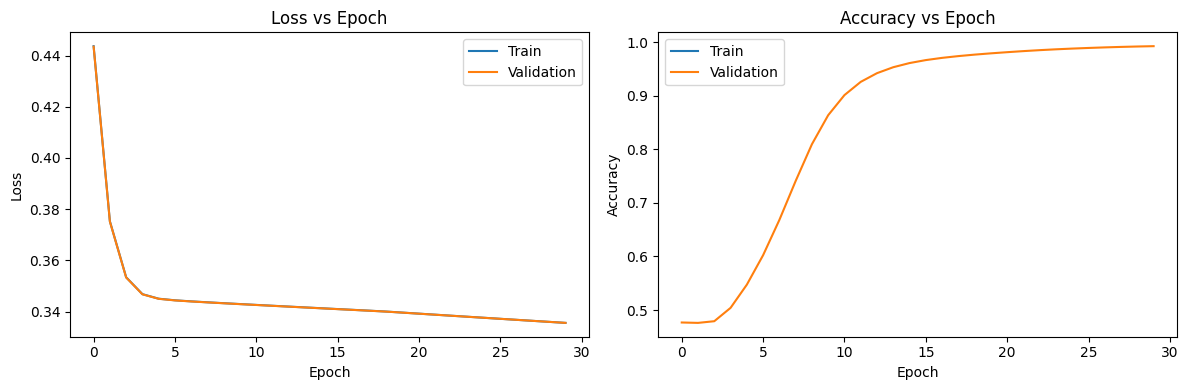

Test Accuracy: 0.9938


In [21]:
# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation
test_acc = compute_accuracy(X_test, y_test, theta)
print(f'Test Accuracy: {test_acc:.4f}')

## Twitter

### Install Dataset

In [22]:
!gdown 1GR3IwbvKNuiVXN5E5eMGyEQtT4pP7kCt

Downloading...
From: https://drive.google.com/uc?id=1GR3IwbvKNuiVXN5E5eMGyEQtT4pP7kCt
To: /content/Twitter_Data.csv
100% 20.9M/20.9M [00:00<00:00, 55.0MB/s]


### Import Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Read Dataset

In [24]:
dataset_path = "Twitter_Data.csv"
df = pd.read_csv(dataset_path)

df = df.dropna()

In [25]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^rt[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Stemming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text

### Apply text normalization


In [27]:
df.columns

Index(['clean_text', 'category'], dtype='object')

In [29]:
df['clean_text'] = df['clean_text'].apply(text_normalize)

### TF-IDF Vectorization


In [30]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

### Add bias term

In [31]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

### One-hot Encoding Labels

In [32]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1

### Train-Val-Test Split


In [33]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

### Model Functions


In [34]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def predict(X, theta):
    z = np.dot(X, theta)
    return softmax(z)

def compute_loss(y_hat, y):
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y * np.log(y_hat), axis=1))

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / X.shape[0]

def update_theta(theta, gradient, learning_rate):
    return theta - learning_rate * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    return np.mean(np.argmax(y_hat, axis=1) == np.argmax(y, axis=1))

### Initialize Parameters

In [35]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]  # Full batch gradient descent
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(low=-0.1, high=0.1, size=(n_features, n_classes))

### Training Loop


In [36]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    # Training
    y_hat = predict(X_train, theta)
    train_loss = compute_loss(y_hat, y_train)
    gradient = compute_gradient(X_train, y_train, y_hat)
    theta = update_theta(theta, gradient, lr)

    # Calculate metrics
    train_acc = compute_accuracy(X_train, y_train, theta)

    val_y_hat = predict(X_val, theta)
    val_loss = compute_loss(val_y_hat, y_val)
    val_acc = compute_accuracy(X_val, y_val, theta)

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n')

Epoch 10/200:
Train Loss: 1.0840, Train Acc: 0.4383
Val Loss: 1.0823, Val Acc: 0.4417

Epoch 20/200:
Train Loss: 1.0737, Train Acc: 0.4413
Val Loss: 1.0723, Val Acc: 0.4451

Epoch 30/200:
Train Loss: 1.0682, Train Acc: 0.4420
Val Loss: 1.0668, Val Acc: 0.4460

Epoch 40/200:
Train Loss: 1.0650, Train Acc: 0.4421
Val Loss: 1.0636, Val Acc: 0.4462

Epoch 50/200:
Train Loss: 1.0631, Train Acc: 0.4421
Val Loss: 1.0616, Val Acc: 0.4462

Epoch 60/200:
Train Loss: 1.0618, Train Acc: 0.4422
Val Loss: 1.0603, Val Acc: 0.4461

Epoch 70/200:
Train Loss: 1.0609, Train Acc: 0.4422
Val Loss: 1.0594, Val Acc: 0.4461

Epoch 80/200:
Train Loss: 1.0602, Train Acc: 0.4422
Val Loss: 1.0586, Val Acc: 0.4461

Epoch 90/200:
Train Loss: 1.0596, Train Acc: 0.4422
Val Loss: 1.0580, Val Acc: 0.4461

Epoch 100/200:
Train Loss: 1.0591, Train Acc: 0.4422
Val Loss: 1.0575, Val Acc: 0.4461

Epoch 110/200:
Train Loss: 1.0586, Train Acc: 0.4422
Val Loss: 1.0570, Val Acc: 0.4462

Epoch 120/200:
Train Loss: 1.0581, Train 

### Visualization


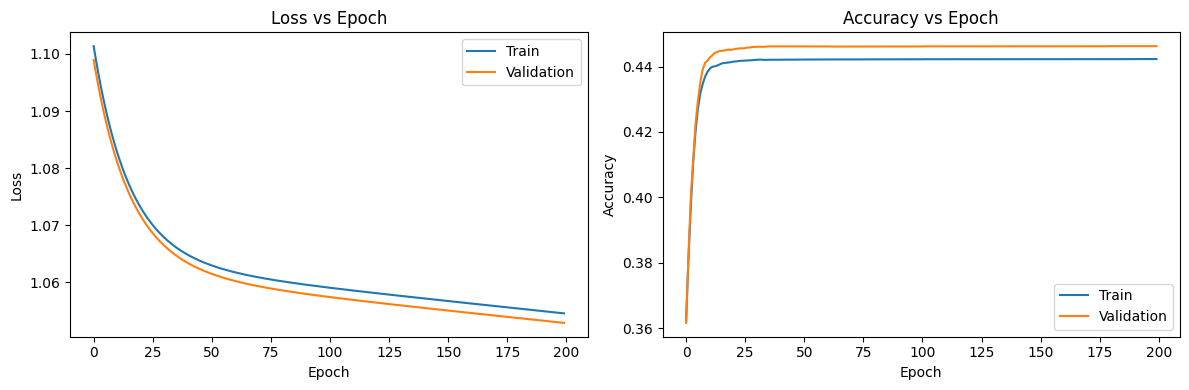

Test Accuracy: 0.4452


In [37]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Final Evaluation
test_acc = compute_accuracy(X_test, y_test, theta)
print(f'Test Accuracy: {test_acc:.4f}')